Based on the RNN example provided in Deep Learning with Python by Francois Chollet

In [3]:
from generator import *
import numpy as np

Prepare training and test datasets. Uses first 100 datapoints (x,v,t) as X, last datapoint as y

In [4]:
train_gen = DuffingGenerator(gamma=0.37)
train_gen.generate(10, [0,0])

print(np.shape(train_gen.u))
print(np.shape(train_gen.t))

X_dats = (np.hstack((train_gen.u, (train_gen.t).reshape((-1, 1))))[:1,:]).flatten()
print(X_dats)

(61, 2)
(61,)
[0. 0. 0.]


In [16]:
def generate_data(gamma, numsamples, time):
    train_gen = DuffingGenerator(gamma=gamma)
    train_gen.generate(time, [0,0])
    X_data = (np.hstack((train_gen.u, (train_gen.t).reshape((-1, 1))))[:10,:]).flatten()
    y_data = (np.hstack((train_gen.u, (train_gen.t).reshape((-1, 1))))[-1,:]).flatten()
    for i in np.linspace(-1.2,1.2,num=numsamples):
        for j in np.linspace(-0.6,0.6,num=numsamples):
            train_gen.generate(time, [i,j])
            X_data = np.vstack((X_data,(np.hstack((train_gen.u, (train_gen.t).reshape((-1, 1))))[:10,:]).flatten()))
            y_data = np.vstack((y_data, (np.hstack((train_gen.u, (train_gen.t).reshape((-1, 1))))[-1,:]).flatten()))
    return X_data, y_data  

In [17]:
X_data, y_data = generate_data(0.37, 500, 10)

D:\Polybox\SyncFolder\XAI_Master\Code\Own\Duffing\generator.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  h = h * min( max( 0.84 * ( tol / r )**0.25, 0.1 ), 4.0 )


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [19]:
input_shape = (np.shape(X_data)[1], 1)

In [20]:
model = Sequential()
model.add(layers.Flatten(input_shape=input_shape))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(3))
model.compile(optimizer=RMSprop(), loss='mae')

history=model.fit(X_data, y_data, steps_per_epoch=10, epochs=100, validation_split=0.3)


Epoch 1/100
10/10 [==============================] - 1s 89ms/step - loss: 3.8909 - val_loss: 3.5285
Epoch 2/100
10/10 [==============================] - 1s 78ms/step - loss: 3.6318 - val_loss: 3.4243
Epoch 3/100
10/10 [==============================] - 1s 78ms/step - loss: 3.4621 - val_loss: 3.3416
Epoch 4/100
10/10 [==============================] - 1s 78ms/step - loss: 3.3104 - val_loss: 3.2757
Epoch 5/100
10/10 [==============================] - 1s 78ms/step - loss: 3.1609 - val_loss: 3.2112
Epoch 6/100
10/10 [==============================] - 1s 78ms/step - loss: 3.0057 - val_loss: 3.1451
Epoch 7/100
10/10 [==============================] - 1s 78ms/step - loss: 2.8432 - val_loss: 3.0726
Epoch 8/100
10/10 [==============================] - 1s 80ms/step - loss: 2.6756 - val_loss: 2.9929
Epoch 9/100
10/10 [==============================] - 1s 77ms/step - loss: 2.4973 - val_loss: 2.9130
Epoch 10/100
10/10 [==============================] - 1s 81ms/step - loss: 2.3065 - val_loss: 2.8341

Plotting Results

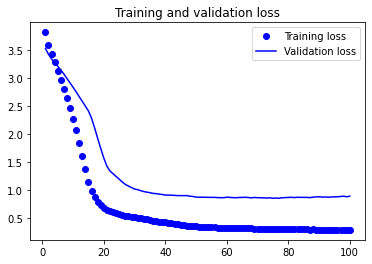

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()

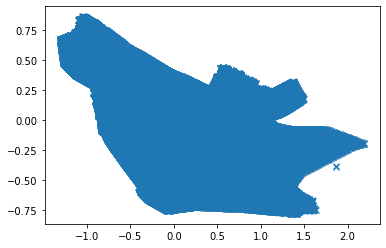

In [22]:
y_pred = model.predict(X_data)
plt.plot(y_pred[:,0], y_pred[:,1], 'x')

In [23]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_data[:100].reshape(100,3,1))



ValueError: cannot reshape array of size 3000 into shape (100,3,1)

In [18]:
np.shape(X_data[-100:].reshape(100,3,1))

(100, 3, 1)

In [20]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_data[-100:].reshape(100,3,1))

AttributeError: 'Partition' object has no attribute 'shap_values'

In [17]:
explainer.expected_value

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.9259776 ,  0.92187417, 10.099669  ], dtype=float32)>

In [19]:

explainer = shap.explainers.Partition(model, X_data[:100])

In [21]:
explainer.explain_row(X_data[101])

TypeError: explain_row() missing 6 required keyword-only arguments: 'max_evals', 'main_effects', 'error_bounds', 'batch_size', 'outputs', and 'silent'

Need a generator to use an RNN

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback= 10
step =1
delay = 100
batch_size = 32


train_gen = generator()

In [114]:
input_shape = (None, X_data.shape[-1])
model = Sequential()
model.add(layers.GRU(32, input_shape=input_shape))
#model.add(layers.Dense(30, activation='relu'))
#model.add(layers.Dense(3))
model.compile(optimizer=RMSprop(), loss='mae')

history=model.fit(X_data, y_data, steps_per_epoch=10, epochs=100, validation_split=0.3)

Epoch 1/100


ValueError: in user code:

    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    D:\Anaconda\envs\Master_Thesis\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_30 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (2800, 30)


In [101]:
X_data.shape[-1]

30